# 2023-10-11 Intro aperture photometry

## Overview

+ Reason through "tricky" aspects of counting pixels
+ Think about how to separate starlight from background

## Part 1: Counting background

In [1]:
from astropy.modeling.models import Gaussian2D
from matplotlib import pyplot as plt

from photutils.aperture import CircularAperture

import numpy as np

In [2]:
def image_with_pixels_labeled(image, pix_precision=0, center_dots=True, ax=None, fig=None, **text_kwargs):
    image_size = image.shape[0]
    if ax is None:
        ax = plt.gca()
    if fig is not None:
        fig = plt.gcf()
    ima = ax.imshow(image)
    if fig is not None:
        fig.colorbar(ima, ax=ax)
    number_format = '{:.' + f'{pix_precision:d}' + 'f}'
    for i in range(image_size):
        for j in range(image_size):
            ax.text(i, j, number_format.format(image[j, i]), 
                     fontweight='bold',
                     horizontalalignment='center',
                     verticalalignment='center',
                     **text_kwargs
                    )
            if center_dots:
                ax.scatter(i, j, marker='.', c='red', alpha=0.5)


In [3]:
rng = np.random.default_rng(seed=548975)

In [4]:
image_size = 10
star_cen = (5, 5)
aperture_radius = 2.1
background_image = rng.poisson(lam=200, size=[image_size, image_size])

In [5]:
def circle(x, y, radius):
    angle = np.linspace(0, 2 * np.pi)
    return x + radius * np.cos(angle), y + radius * np.sin(angle)

In [6]:
circ = circle(*star_cen, aperture_radius)

## Part 2: Now with a star....

In [7]:
star = Gaussian2D(amplitude=200, x_stddev=1.25, y_stddev=1.25)
grids = np.mgrid[0:image_size, 0:image_size]
star_grid = star(grids[0] - star_cen[0], grids[1] - star_cen[1])

In [8]:
total_image = background_image + star_grid

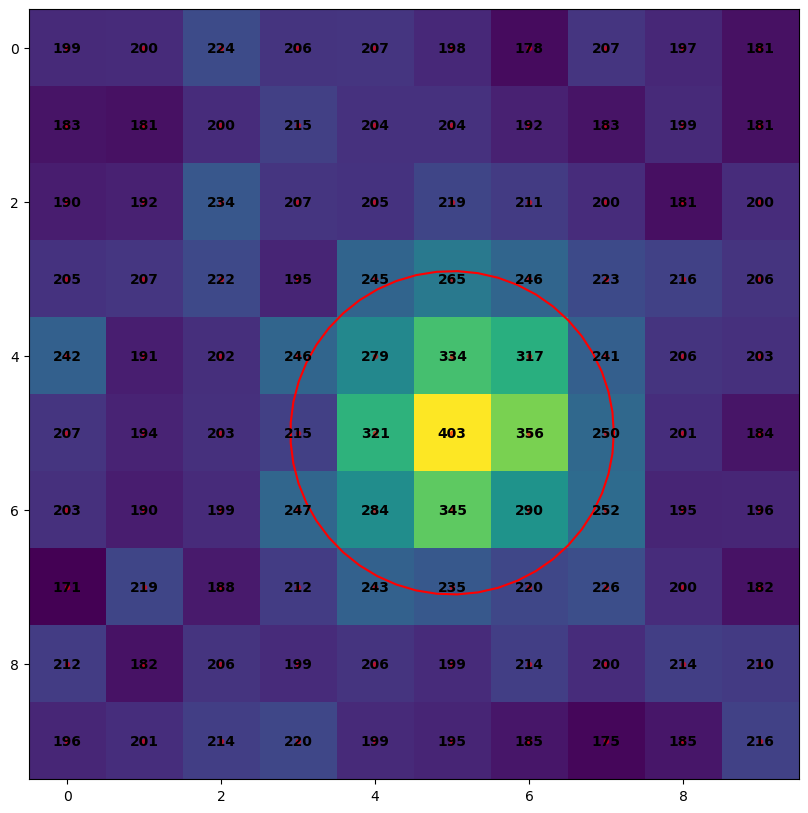

In [9]:
plt.figure(figsize=(10, 10))
image_with_pixels_labeled(total_image)

plt.plot(circ[0], circ[1], color='red');
        

In [10]:
ap = CircularAperture(star_cen, aperture_radius)

In [11]:
ap.area_overlap(total_image, method='center'), ap.area_overlap(total_image, method='exact'), ap.area_overlap(total_image, method='subpixel')

(13.0, 13.85442360233099, 13.96)

In [12]:
ap.do_photometry(total_image, method='center'), ap.do_photometry(total_image, method='exact'), ap.do_photometry(total_image, method='subpixel')

((array([3895.18300926]), array([], dtype=float64)),
 (array([4106.01025915]), array([], dtype=float64)),
 (array([4131.58209032]), array([], dtype=float64)))

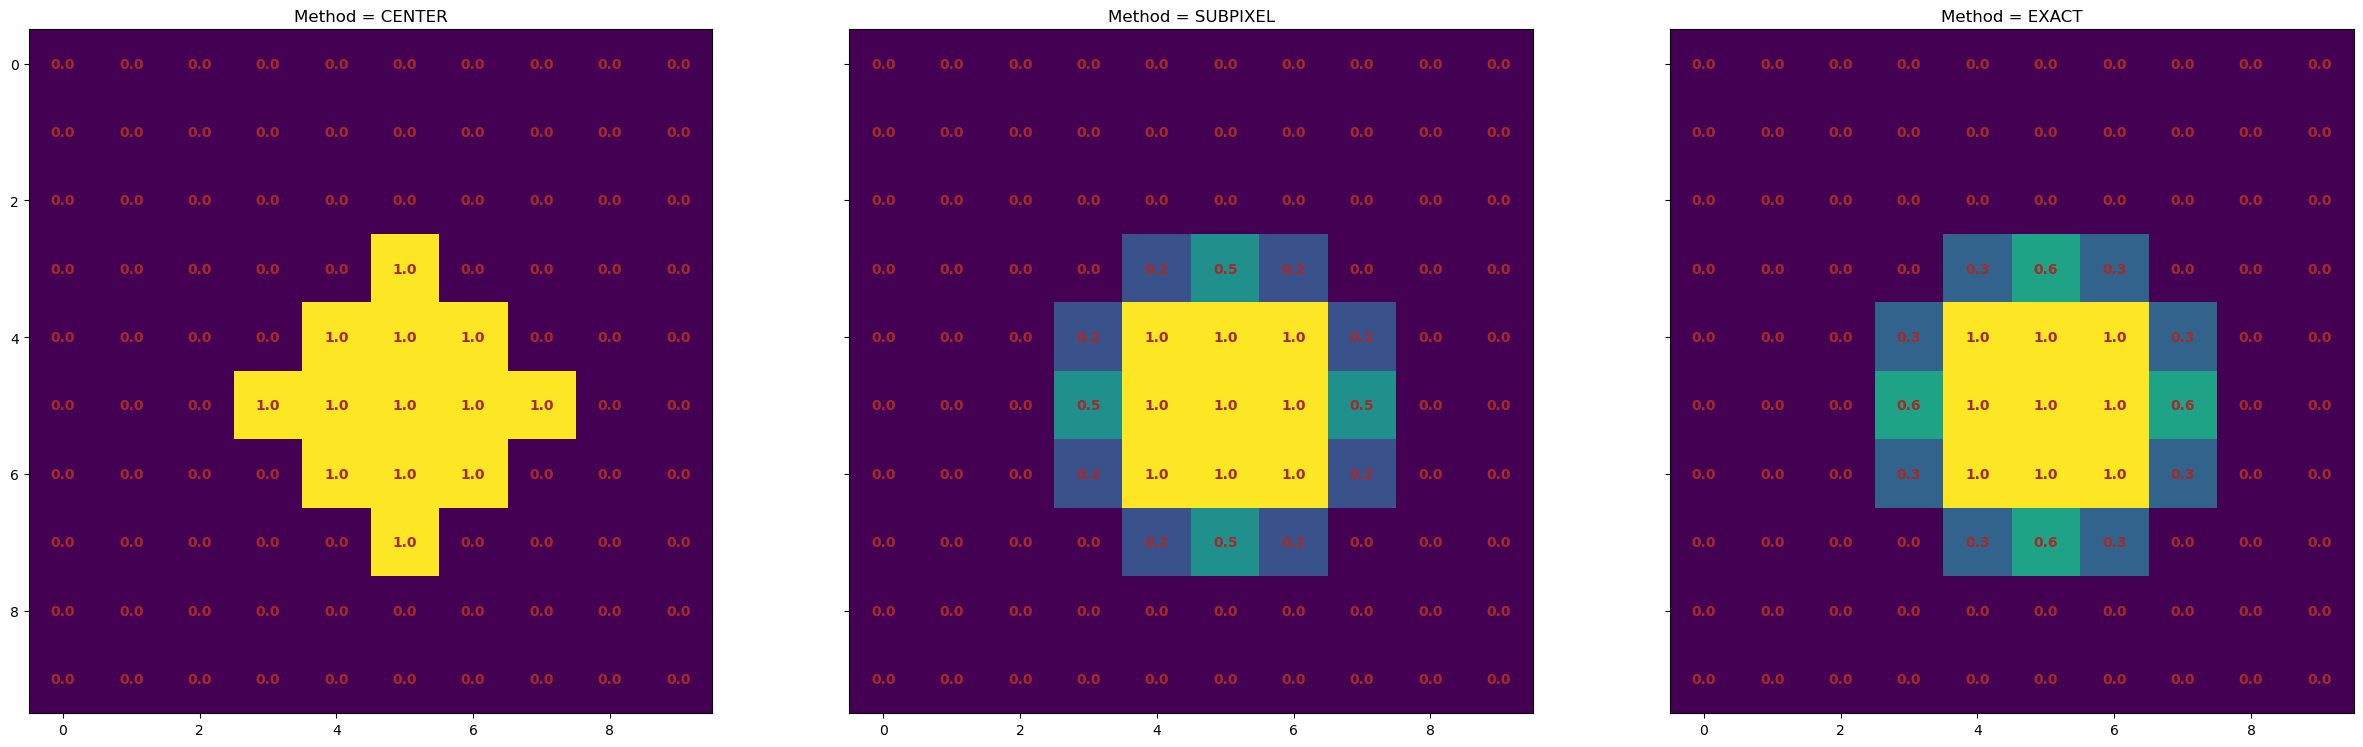

In [13]:
methods = ['center', 'subpixel', 'exact']

fig, axs = plt.subplot_mosaic('ABC', sharey=True, figsize=(30, 10))

for method, ax in zip(methods, axs.values()):
    if method == 'subpixel':
        subarg = {'subpixel': 2}
    else:
        subarg = {}
    ap_mc = ap.to_mask(method=method, subpixels=2)
    if method == 'exact':
        fig_arg = {'fig': fig}
        
    else:
        fig_arg = {}
    image_with_pixels_labeled(ap_mc.to_image(total_image.shape), pix_precision=1, ax=ax, center_dots=False, color="brown")
    ax.set_title(f'Method = {method.upper()}')